# Author: Kiril Klein (UCPH-ID: fjn197) {-}
I, Kiril Klein expressly vow to uphold my scientific, academic, and moral integrity by working individually on this exam and soliciting no direct external help or assistance.

In [1]:
import sys
sys.path.append('../')

In [6]:
#import warnings
#warnings.filterwarnings("ignore")
#%config Completer.use_jedi = False

In [403]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import toolbox as tb
from toolbox import fits, vis
from toolbox import as_toolbox as ast
from toolbox.vis import Color_palette as Color_p
import urllib
from scipy import stats
from toolbox.ExternalFunctions import NLLH
import importlib
from numba import jit
#from mayavi import mlab
#import nestle
#import corner
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import dtale

# Problem 1 {-}

A maximum likelihood fit was performed to estimate best-fit parameters. The data was then binned using 50 bins from the minimal to the maximal value of the range. Binned data was used to compute a $\chi^2$ value and to detemine the correpsonding p-value. A function is rejected if the p-value is below 0.05.

In [12]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Prob1.txt"
D1 = pd.read_csv(url, sep=r" ", header = None, engine='python')
D1

,0,1,2,3,4
0,22.173312,0.164244,11.0,1.144988,2.412222
1,20.695507,-0.552985,9.0,1.190298,0.979081
2,21.777940,-0.219681,12.0,1.107390,1.500416
3,23.014198,0.609531,10.0,1.206525,1.445337
4,22.827932,0.810382,11.0,1.075362,0.353018
...,...,...,...,...,...
5114,20.190279,0.997232,9.0,1.100780,1.630028
5115,23.387307,0.619276,16.0,1.166039,2.233176
5116,20.491821,0.810158,14.0,1.237308,1.915955
5117,25.731616,0.316386,6.0,1.097451,2.068088


In [14]:
D1.iloc[:,3]

0       1.144988
1       1.190298
2       1.107390
3       1.206525
4       1.075362
          ...   
5114    1.100780
5115    1.166039
5116    1.237308
5117    1.097451
5118    1.132097
Name: 3, Length: 5119, dtype: float64

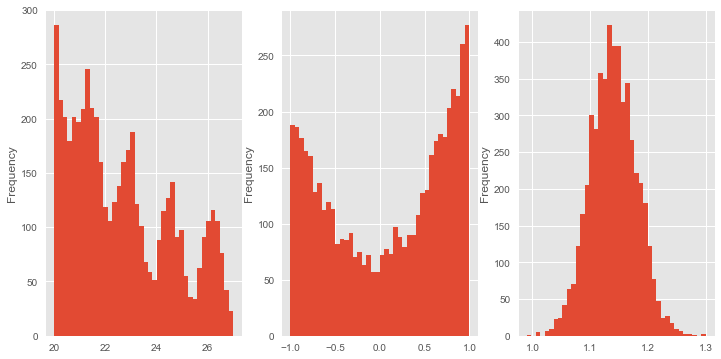

In [431]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1,3, figsize = (12,6))
ax = ax.flatten()
for i,j in enumerate([0,1,3]):
    D1.iloc[:,j].plot.hist(legend=False, bins = 40, ax = ax[i])

In [255]:
#Test all 3 pdfs for the first column
def f0(x, a,b,c):
    xmax = 27
    xmin = 20
    Norm = -1/a*(np.cos(a*xmax)-np.cos(a*xmin)) + 1/b*c*(np.exp(b*xmax)-np.exp(b*xmin)) 
    return (np.sin(a*x)+c*np.exp(b*x)+1)/Norm

def f1(x, a, b): return (1+ a*x + b*x**2)/(2+2/3*b)
#For the third column we have poisson, binomial, maybe logarithmic
def f3(x, a, b): return stats.norm.pdf(x, loc = a, scale = b)

def f_chi2(O, E): return np.sum((O-E)**2/E)

## col 0 

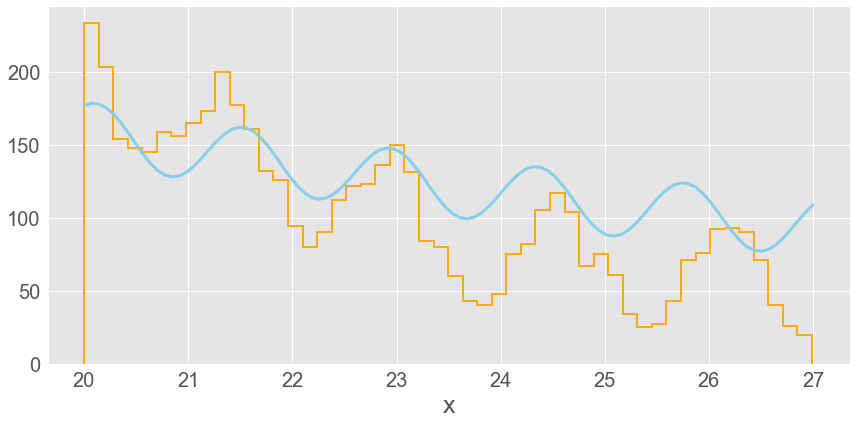

In [214]:
x0 = np.linspace(20,27,100)
fd0 = vis.nice_histogram(D1.iloc[:,0], 50)
p0 = [4.45,-.09,40]
fig, ax = vis.nice_plot(x0, f0(x0, *p0)*len(D1)*fd0['binwidth'], figure = fd0['fig'], axis = fd0['ax'])
fig

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  """


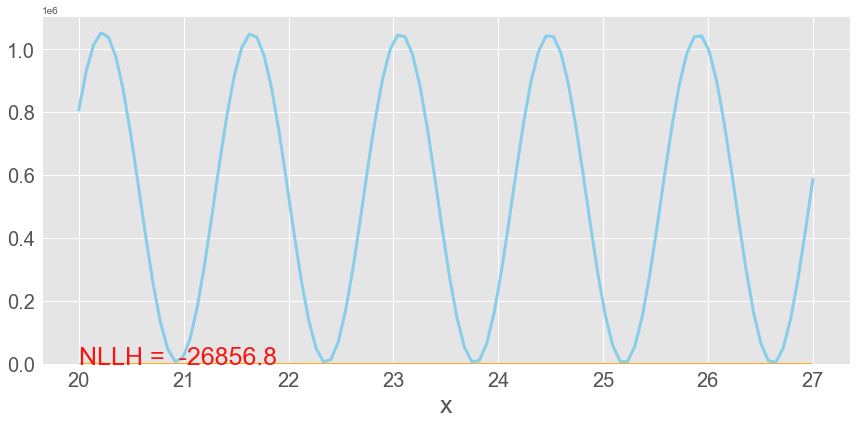

In [226]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt0 = fits.hist_fit(
    f0, D1.iloc[:,0], p0, fit_type = 'ullh',
    observed = True, print_level = 0)
a0m, b0m, c0m = dt0['minuit_obj'].values[:]
fd0 = vis.nice_histogram(D1.iloc[:,0], 50)
p00 = [4.2,-.11,40]
fig, ax = vis.nice_plot(
    x0, f0(x0, a0m, b0m, c0m)*len(D1)*fd0['binwidth'], 
    figure = fd0['fig'], axis = fd0['ax'])
#Both seem to fit reasonably well
LLH0 = dt0['minuit_obj'].fval
ax.text(20, 10, f"NLLH =  {LLH0:2.1f}", color = Color_p(2)[0],fontsize = 25)
fig

## Col1 

In [216]:
x1 = np.linspace(-1,1,100)
fd1 = vis.nice_histogram(D1.iloc[:,1], 50)
p1 = [1,1]
fig, ax = vis.nice_plot(x1, f1(x1, *p1)*len(D1)*fd1['binwidth'], figure = fd1['fig'], axis = fd1['ax'])

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  """


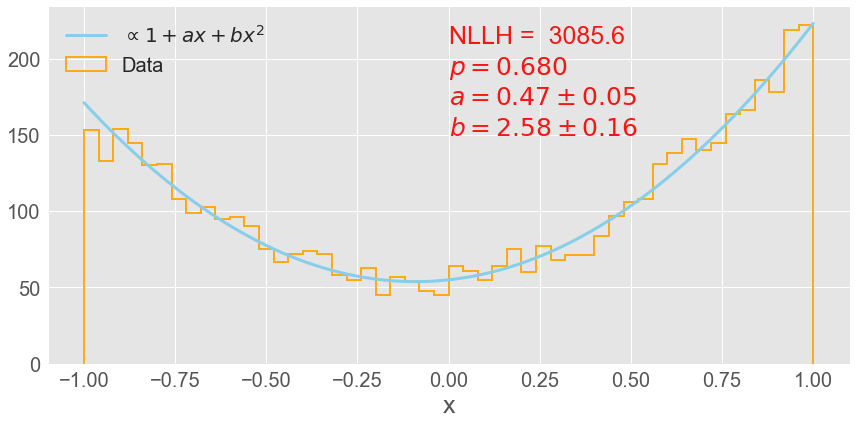

In [263]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt1 = fits.hist_fit(
    f1, D1.iloc[:,1], p1, fit_type = 'ullh',
    observed = True, print_level = 0)
a1m, b1m = dt1['minuit_obj'].values[:]
sa1m, sb1m = dt1['minuit_obj'].errors[:]
fd1 = vis.nice_histogram(D1.iloc[:,1], 50, data_label_hist='Data')
p00 = [4.2,-.11,40]
fig, ax = vis.nice_plot(
    x1, f1(x1, a1m, b1m)*len(D1)*fd1['binwidth'],  plot_legend=True, label_fs=25,
    figure = fd1['fig'], axis = fd1['ax'], data_label = r"$\propto 1+ax+bx^2$")
#Both seem to fit reasonably well
LLH1 = dt1['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 170, r"$a = 0.47\pm0.05$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 2.58\pm0.16$", color = Color_p(2)[0],fontsize = 25)
#compute chi2 and pvalue using 50 bins
chi21 = f_chi2(fd1['y'], f1(fd1['x'],a1m, b1m))
pval1 = stats.chi2.sf(chi21, len(D1)-2)
ax.text(0, 190, r"$p = 0.680$", color = Color_p(2)[0],fontsize = 25)
fig

In [261]:
pval1

0.6801123262411332

## Col 3

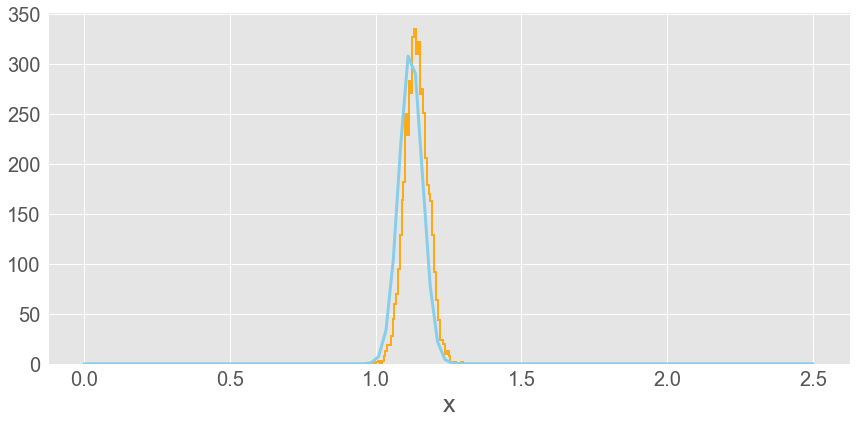

In [228]:
x3 = np.linspace(0,2.5,100)
fd3 = vis.nice_histogram(D1.iloc[:,3], 50)
p3 = [1.12,.04]
fig, ax = vis.nice_plot(x3, f3(x3, *p3)*len(D1)*fd3['binwidth'], figure = fd3['fig'], axis = fd3['ax'])
fig

In [247]:
b3m, sb3m

(0.03960343270275993, 0.00039140191796361624)

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  """


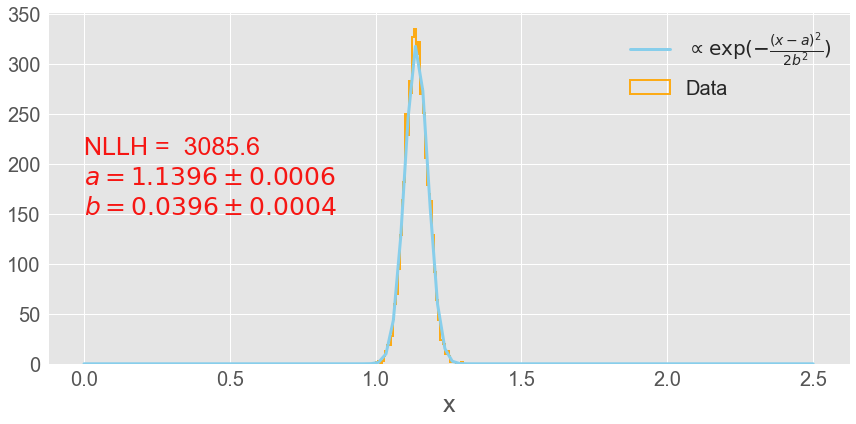

In [253]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt3 = fits.hist_fit(
    f3, D1.iloc[:,3], p3, fit_type = 'ullh',
    observed = True, print_level = 0)
a3m, b3m = dt3['minuit_obj'].values[:]
sa3m, sb3m = dt3['minuit_obj'].errors[:]
fd3 = vis.nice_histogram(D1.iloc[:,3], 50, data_label_hist='Data',label_fs=25)
fig, ax = vis.nice_plot(
    x3, f3(x3, a3m, b3m)*len(D1)*fd3['binwidth'],  plot_legend=True,
    figure = fd3['fig'], axis = fd3['ax'], data_label = r"$\propto \exp{( -\frac{(x-a)^2}{2b^2})  }$")
#Both seem to fit reasonably well
LLH3 = dt3['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 180, r"$a = 1.1396\pm0.0006$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 0.0396\pm0.0004$", color = Color_p(2)[0],fontsize = 25)
fig

# Problem 2 {-} 

## Problem 2a {-}

Running 10000 pseudo-experiments in producing isotropic points on a unit sphere will be used to determine a test statistic for the KS-value. This will then be used to determine whether the data follows uniform distribution in $\varphi$ and $\cos{(\theta)}$. 

In [324]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Problem2.txt"
D2 = np.loadtxt(url , skiprows = 2)
d_phi = D2[:,0]#azimuth angle from 0 to 2*pi
d_theta = D2[:,1]#zenith angle from 0 to pi

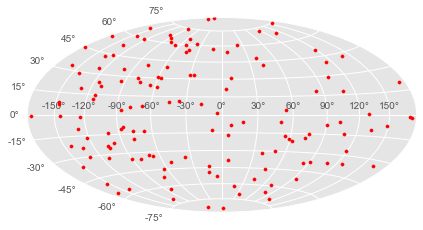

In [321]:
plt.figure(figsize = (6,6))
plt.subplot(projection="hammer")
plt.scatter(d_phi-np.pi, d_theta-np.pi/2,  s=10, c='r', zorder=10)
plt.grid(True)
plt.tight_layout()
#Is this uniform? 

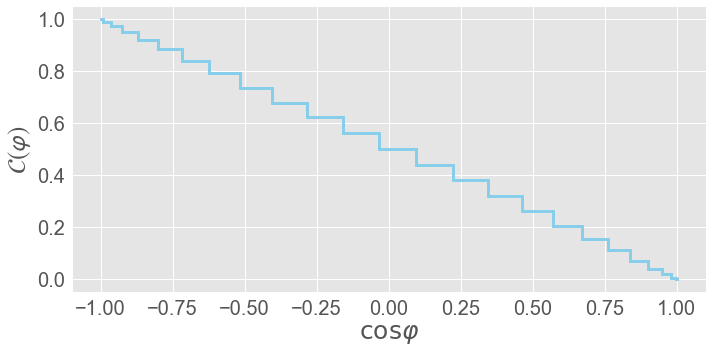

In [486]:
#Autocorrelation for data
Npoints = len(D2)
nphi = 50
d_3d = ast.create_points3d(d_phi, d_theta)
x_phi = np.linspace(0, 2*np.pi,nphi)
iso = ast.f_isotropic(x_phi)#isotropic for large number of events
CAR_data = ast.cumulative_autocorrelation(d_3d, x_phi)
fig, ax = vis.nice_plot(
    np.cos(x_phi), CAR_data, drawstyle = 'steps-mid',
    xlabel = r"$\cos{\varphi}$", ylabel = r"$\mathcal{C(\varphi)}$")

In [493]:
import importlib
_=importlib.reload(ast)

In [511]:
#Produce pseudo experiments
Nexp = int(500)
#accelerate with numba
#@jit(forceobj = True)
def simulate_KS(Nexp):
    KS_iso = np.empty(Nexp)
    for i in range(Nexp):
        X_iso = ast.sample_spherical_uniform(Npoints)
        KS_iso[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_iso, x_phi)-iso))
    return KS_iso

In [513]:
KS_iso = simulate_KS(Nexp)
KS_data = np.max(np.abs(CAR_data-iso))

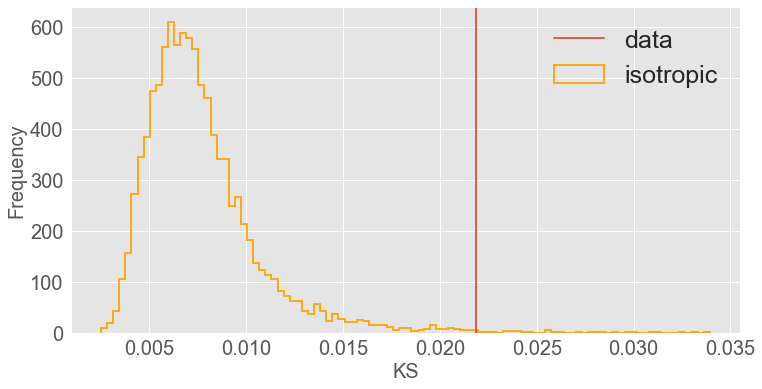

In [489]:
fd = vis.nice_histogram(
    KS_iso, 100, data_label_hist='isotropic', xlabel = 'KS',
    plot_legend=True)
fd['ax'].axvline(KS_data, label = 'data')
fd['ax'].legend(fontsize = 25)
fd['fig']

In [514]:
#compute integral
KSx, KSy = fd['x'], fd['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

0.0038


The integral is 0.0044 which corresponds to the p-value. We can reject the isotropic hypothesis for the data.

## Problem 2b {-} 

In [515]:
Nexp = 10
Nuniform = int(Npoints*0.8)
Nha = int(Npoints*0.2)
aphi = np.random.uniform(size = Nha)*(0.725-0.225)*np.pi + 0.225*np.pi
atheta = np.random.uniform(size = Nha)*(1-0.3)*np.pi + 0.3*np.pi
#@jit(forceobj = True)
def simulate_KS_HA(Nexp):
    KS_HA = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HA = ast.create_points3d(aphi, atheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HA = np.concatenate((X_HA, X_iso), axis = 1)
        KS_HA[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HA, x_phi)-iso))
    return KS_HA

In [516]:
%time KS_HA = simulate_KS_HA(100)

Wall time: 1.12 s


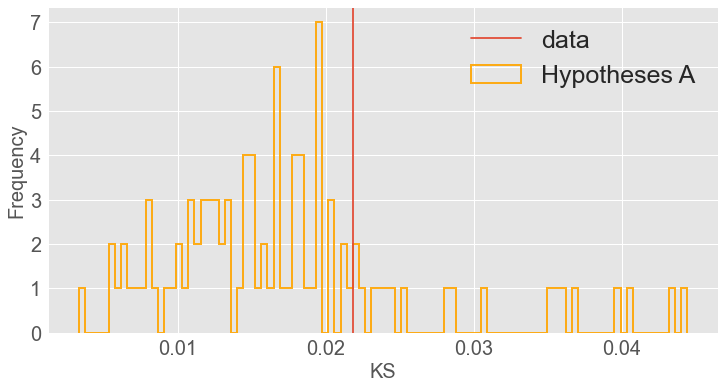

In [517]:
fdA = vis.nice_histogram(
    KS_HA, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdA['ax'].axvline(KS_data, label = 'data')
fdA['ax'].legend(fontsize = 25)
fdA['fig']

In [518]:
#compute integral
KSx, KSy = fdA['x'], fdA['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

0.19


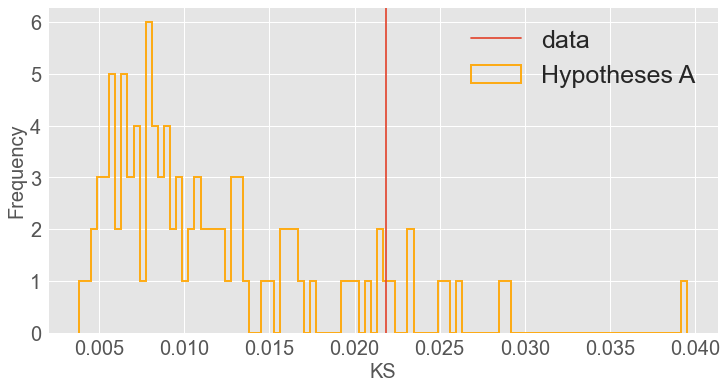

In [519]:
Nexp = 10
NuniformB = int(Npoints*0.85)
NHB = int(Npoints*0.15)
bphi = np.random.uniform(size = NHB)*np.pi 
btheta = np.random.uniform(size = NHB)*0.5*np.pi + 0.5*np.pi
@jit(forceobj = True)
def simulate_KS_HB(Nexp):
    KS_HB = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HB = ast.create_points3d(bphi, btheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HB = np.concatenate((X_HB, X_iso), axis = 1)
        KS_HB[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HB, x_phi)-iso))
    return KS_HB
KS_HB = simulate_KS_HB(100)
fdB = vis.nice_histogram(
    KS_HB, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdB['ax'].axvline(KS_data, label = 'data')
fdB['ax'].legend(fontsize = 25)
fdB['fig']

In [462]:
#compute integral
KSx, KSy = fdB['x'], fdB['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

0.12


How to compare two hypothesis to each other. Definitely we reject isotropic and

# Problem 3 {-} 

# Problem 4 {-} 

# Problem 5 {-}